In [1]:
# %matplotlib widget

# Explore Taylor series expansion of functions using JAX jet module

Recommended reads:
- [Taylor-Mode Automatic Differentiation for Higher-Order Derivatives in JAX](https://openreview.net/forum?id=SkxEF3FNPH) by Jesse Bettencourt, Matthew J. Johnson, and David Duvenaud
- [Notes for jax.experimental.jet module](https://github.com/jax-ml/jax/files/6717197/jet.pdf)
- [Evaluating higher derivative tensors by forward propagation of univariate Taylor series](https://doi.org/10.1090/S0025-5718-00-01120-0) by Andreas Griewank, Jean Utke and Andrea Walther


In [1]:
import itertools

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from griewank import deriv_list
from jax.experimental import jet
from scipy.special import factorial

jax.config.update("jax_enable_x64", True)

## Univariate expansion

Example of Taylor series expansion of $\cos(x)$ function around $x=x_0$.

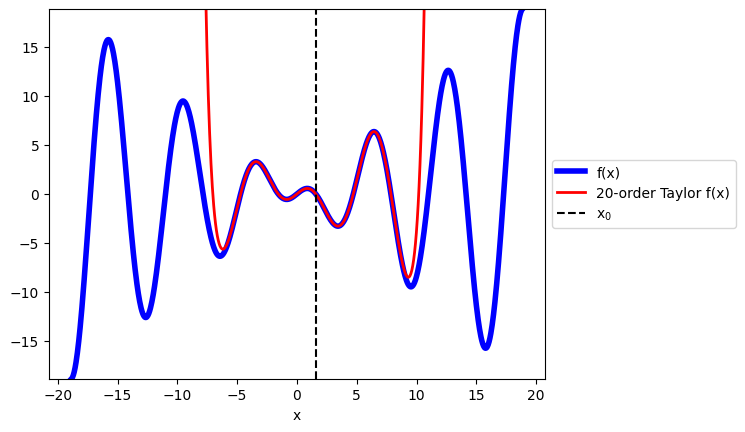

In [6]:
func = lambda x: jnp.cos(x) * x


def func_taylor(x, x0, c):
    """Evaluates Taylor series: sum_i c[i] / i! * (x - x0)**i"""
    dx = x - x0

    @jax.jit
    def pow(carry, i):
        dx_i, res = carry
        dx_i *= dx / i
        res = res + c[i] * dx_i
        return (dx_i, res), 0

    (_, res), _ = jax.lax.scan(
        pow, (jnp.ones_like(dx), jnp.ones_like(dx) * c[0]), jnp.arange(1, len(c))
    )
    return res


x = np.linspace(-6 * np.pi, 6 * np.pi, 1000)

order = 20
deg = [0.0] * order
deg[0] = 1.0

x0 = np.pi / 2
c0, c = jet.jet(func, (x0,), (deg,))
c = jnp.array([c0] + c)

f = func(x)
f_taylor = func_taylor(x, x0, c)

plt.plot(x, f, "b", label="f(x)", linewidth=4)
plt.plot(x, f_taylor, "r", label=f"{order}-order Taylor f(x)", linewidth=2)

plt.plot([x0, x0], [np.min(f), np.max(f)], "k--", label="x$_0$")
plt.ylim([np.min(f), np.max(f)])
plt.xlabel("x")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Multivariate expansion

Example of Taylor series expansion of $\cos(x_1)\sin(x_2)$.

First, compare the Taylor series expansion coefficients obtained using the interpolation scheme of Griewank, et al. (see references above) with the recurrent application of `jacfwd`.

In [9]:
func = lambda x: jnp.cos(x[0]) * jnp.sin(x[1]) * x[1]


def jacfwd(x0, ind):
    """Inefficient recurrent calculation of derivatives using forward propagation"""
    f = func
    for _ in range(sum(ind)):
        f = jax.jacfwd(f)
    i = sum([(i,) * o for i, o in enumerate(ind)], start=tuple())
    return f(x0)[i]


max_order = 10
x0 = np.array([0.0, 0.0])
deriv_ind = [
    elem
    for elem in itertools.product(*[range(0, max_order + 1) for _ in range(2)])
    if sum(elem) <= max_order
]

c = deriv_list(func, deriv_ind, x0, if_taylor=True)
c2 = np.array([jacfwd(x0, ind) / np.prod(factorial(ind)) for ind in deriv_ind])
maxdiff = np.max(np.abs(c - c2))
print(
    f"Max difference between 'deriv_list' and 'jacfwd (max order = {max_order}):'",
    maxdiff,
)

Max difference between 'deriv_list' and 'jacfwd (max order = 10):' 8.243405957841787e-15


Plot Taylor series expansion

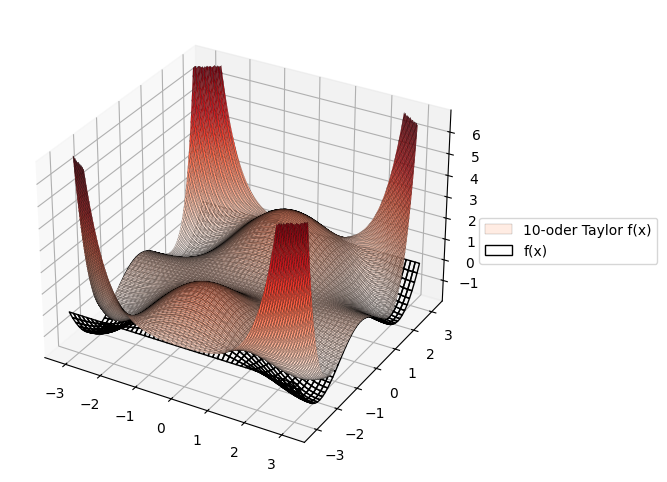

In [25]:
@jax.jit
def func_taylor(x, x0, ind, c):
    """Evaluates Taylor series: sum_i c[i] * (x - x0)**ind[i]"""
    dx = x - x0
    return jnp.sum(
        jnp.prod(dx[:, None, :] ** jnp.asarray(ind)[None, :, :], axis=-1) * c, axis=-1
    )


x = np.linspace(-np.pi, np.pi, 1000)
nx = len(x)
xa, xb = np.meshgrid(x, x, indexing="ij")
x = np.column_stack([xa.ravel(), xb.ravel()])
f = jax.vmap(func, in_axes=0)(x)
f_taylor = func_taylor(x, x0, deriv_ind, c)


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

f_taylor = np.array(f_taylor)
f_taylor[f_taylor > np.max(f) + 5] = None
f_taylor[f_taylor < np.min(f) - 5] = None

ax.plot_surface(
    xa,
    xb,
    f_taylor.reshape(nx, -1),
    cmap="Reds",
    edgecolor="black",
    linewidth=0.1,
    rstride=5,
    cstride=5,
    label=f"{max_order}-oder Taylor f(x)"
)

ax.plot_surface(
    xa,
    xb,
    f.reshape(nx, -1),
    cmap="Blues",
    edgecolor="black",
    linewidth=1,
    rstride=20,
    cstride=20,
    alpha=0.0,
    label="f(x)"
)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()